In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, BatchNormalization, Dense, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [ ]:

data = pd.read_csv('Walmart.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week'] = data['Date'].dt.isocalendar().week

data['Weekly_Sales_Lag_1'] = data['Weekly_Sales'].shift(1)
data['Weekly_Sales_Rolling_Mean_4'] = data['Weekly_Sales'].shift(1).rolling(window=4).mean()
data['Weekly_Sales_Rolling_Std_4'] = data['Weekly_Sales'].shift(1).rolling(window=4).std()

data = data.dropna()
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Week,Weekly_Sales_Lag_1,Weekly_Sales_Rolling_Mean_4,Weekly_Sales_Rolling_Std_4
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5,9,1409727.59,1.576836e+06,112353.415114
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,2010,3,12,10,1554806.68,1.554615e+06,103135.002548
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,2010,3,19,11,1439541.59,1.504011e+06,95360.050839
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,2010,3,26,12,1472515.79,1.469148e+06,62599.457150
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,2010,4,2,13,1404429.92,1.467823e+06,64308.381016


In [ ]:

features = data.drop(columns=['Weekly_Sales', 'Date'])
label = data['Weekly_Sales']

features['Store'] = features['Store'].astype('category')

features = pd.get_dummies(features, columns=['Store'], prefix='store')

features = features.astype({col: 'int' for col in features.columns if 'store_' in col})

print(features.head())




   Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  Year  \
4             0        46.50       2.625  211.350143         8.106  2010   
5             0        57.79       2.667  211.380643         8.106  2010   
6             0        54.58       2.720  211.215635         8.106  2010   
7             0        51.45       2.732  211.018042         8.106  2010   
8             0        62.27       2.719  210.820450         7.808  2010   

   Month  Day  Week  Weekly_Sales_Lag_1  ...  store_36  store_37  store_38  \
4      3    5     9          1409727.59  ...         0         0         0   
5      3   12    10          1554806.68  ...         0         0         0   
6      3   19    11          1439541.59  ...         0         0         0   
7      3   26    12          1472515.79  ...         0         0         0   
8      4    2    13          1404429.92  ...         0         0         0   

   store_39  store_40  store_41  store_42  store_43  store_44  store_45  


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_features = MinMaxScaler()
features = pd.DataFrame(scaler_features.fit_transform(features), columns=features.columns)

scaler_target = MinMaxScaler()
label = scaler_target.fit_transform(label.values.reshape(-1, 1)).flatten()
x_train, x_test, y_train, y_test = train_test_split(features, label, random_state=42, test_size=0.3)
x_train_lstm = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_lstm = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(f"Training data shape (LSTM input): {x_train_lstm.shape}")
print(f"Test data shape (LSTM input): {x_test_lstm.shape}")

Training data shape (LSTM input): (4501, 1, 57)
Test data shape (LSTM input): (1930, 1, 57)


In [ ]:

model = Sequential([
    Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(x_train_lstm, y_train, epochs=300, batch_size=32, verbose=1, validation_data=(x_test_lstm, y_test), callbacks=[early_stopping])

y_pred = model.predict(x_test_lstm)


Epoch 1/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0748 - mae: 0.2231 - val_loss: 0.0591 - val_mae: 0.1912
Epoch 2/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0532 - mae: 0.1782 - val_loss: 0.0340 - val_mae: 0.1405
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0314 - mae: 0.1351 - val_loss: 0.0190 - val_mae: 0.1099
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0193 - mae: 0.1098 - val_loss: 0.0146 - val_mae: 0.0968
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0150 - mae: 0.0972 - val_loss: 0.0107 - val_mae: 0.0815
Epoch 6/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - mae: 0.0812 - val_loss: 0.0065 - val_mae: 0.0603
Epoch 7/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076 - mae: 0.0652 - val_loss: 0.0038 - val_mae: 0.0425
Epoch 8/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061 - mae: 0.0548 - val_loss: 0.0031 - val_mae: 0.0352
Epoch 9/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

In [ ]:
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"Test MAPE: {mape}")
print(f"Test R²: {r2}")

Test MAPE: 0.06320691823145251
Test R²: 0.9689286043165609


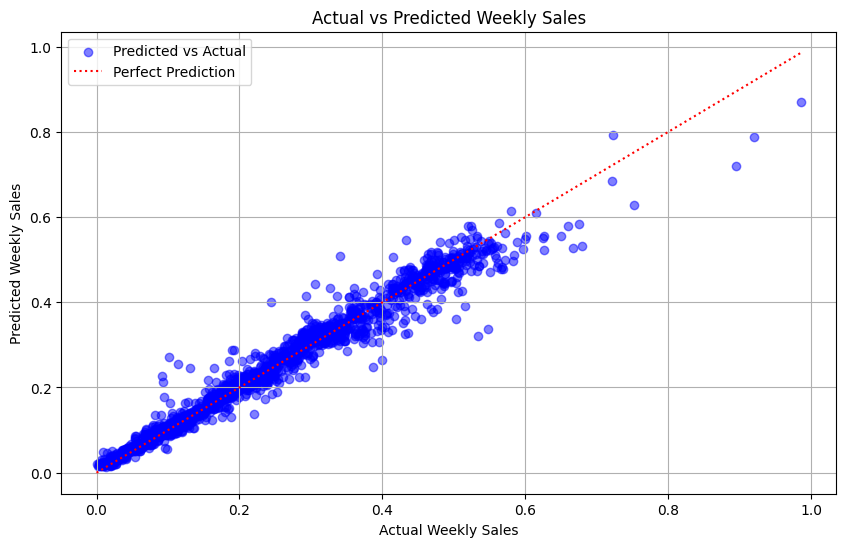

In [ ]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dotted', label='Perfect Prediction')
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pickle
with open('LSTM.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Create a list to hold the sample data for the table
samples_data = []

# Loop through 5 random samples from the test set
for i in range(5):
    # Select a random sample from the test set
    sample_index = np.random.randint(0, x_test_lstm.shape[0])  # Random index from the test set

    # Get the corresponding parameters for the sample (first 6 columns)
    sample_features = x_test.iloc[sample_index, :6]
    sample_actual_value = y_test.iloc[sample_index]
    sample_predicted_value = y_pred[sample_index]

    # Inverse transform the first 6 standardized features for better interpretation
    sample_features_original = pd.DataFrame(scaler.inverse_transform([x_test.iloc[sample_index]]), columns=x_test.columns)
    sample_features_original = sample_features_original.iloc[:, :6]  # Select first 6 columns

    # Add the data to the list (flatten the feature values)
    samples_data.append([*sample_features_original.values.flatten(), sample_actual_value, sample_predicted_value[0]])

# Create a DataFrame from the collected data
columns = list(sample_features_original.columns) + ['Actual Weekly Sales', 'Predicted Weekly Sales']
samples_df = pd.DataFrame(samples_data, columns=columns)

# Display the table
print(samples_df)



Random Sample of 5 Actual vs Predicted values:
         Actual  Predicted
1118  0.119705   0.132816
1654  0.196007   0.196127
1865  0.109797   0.110918
941   0.409018   0.433345
331   0.033400   0.042361
